# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [1]:
DATA_DIR = '/data'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

## Download and extract files

In [2]:
import os.path
from os import path

for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:
  if path.exists(pth) == False:
    os.mkdir(pth)

In [3]:
#only run this cell once, at the start
import requests, os

train_zip = "train.zip"
test_zip = "test.zip"
sample_sub = "SampleSubmission.csv"

In [4]:
#!unzip "/content/train/train.zip" -d "/content/train/"
#!unzip "/content/test/test.zip" -d "/content/test/"

# Data Prep

## Import Libraries

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

import warnings
warnings.simplefilter('ignore')

# Modelling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier #Stohastic gradient descent
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer, KNNImputer
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format
import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [6]:
#!pip install lightgbm

In [7]:
from os import path
import sys
sys.path.append(path.abspath('../')) #replace this path with your own path
from custom_python_functions.model_evaluation import (
    train_crossval_predict_score,
    predict_and_print_scores,
    plot_confusion_matrix,
    plot_distributions,
    plot_correlation,
    plot_roc_curves,
    find_roc_threshold_tpr,
    find_roc_threshold_fpr,
    find_roc_threshold_accuracy,
    find_roc_threshold_f1)

## Read the Data

In [8]:
import pandas as pd

client = pd.read_csv('data/train/client_train.csv', low_memory=False)
invoice = pd.read_csv('data/train/invoice_train.csv', low_memory=False)

Columns:

- Client_id: Unique id for client
- District: District where the client is
- Client_catg: Category client belongs to
- Region: Area where the client is
- Creation_date: Date client joined
- Target: fraud:1 , not fraud: 0

- Tarif_type: Type of tax
- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
- Counter_code:
- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- Consommation_level_1: Consumption_level_1
- Consommation_level_2: Consumption_level_2
- Consommation_level_3: Consumption_level_3
- Consommation_level_4: Consumption_level_4
- Months_number: Month number
- Counter_type: Type of counter

## Data Understanding

In [9]:
#compare size of the various datasets
print(client.shape, invoice.shape)

(135493, 6) (4476749, 16)


In [10]:
#print top rows of dataset
#invoice.head()

In [11]:
#client.head(5)

In [12]:
#Get a summary for all numerical columns
#invoice.describe()

In [13]:
#Get a summary for all numerical columns
#client.describe()

In [14]:
#Get concise information of each column in dataset
#invoice.info()

In [15]:
#Get concise information of each column in dataset
#client.info()

In [16]:
#Getting unique values on the invoice train data
for col in invoice.columns:
    print(f"{col} - {invoice[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [17]:
#Getting unique values on the invoice train data
for col in client.columns:
    print(f"{col} - {client[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [18]:
#check for missing values
#invoice.isnull().sum()

In [19]:
#check for missing values
#client.isnull().sum()

No missing values in train set

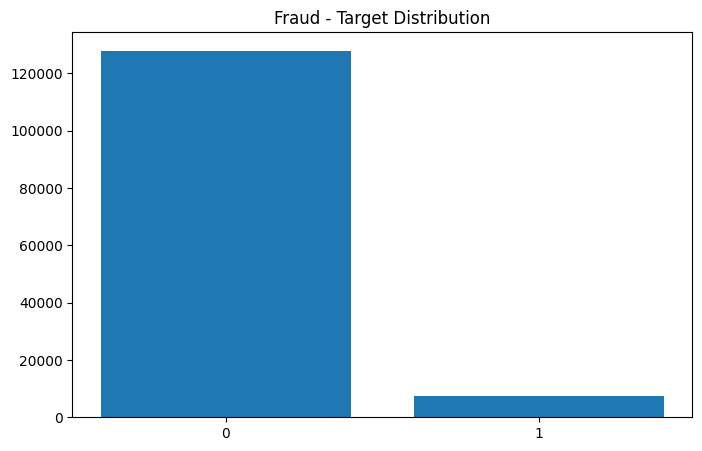

In [20]:
#Visualize fraudulent activities
fraudactivities = client.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

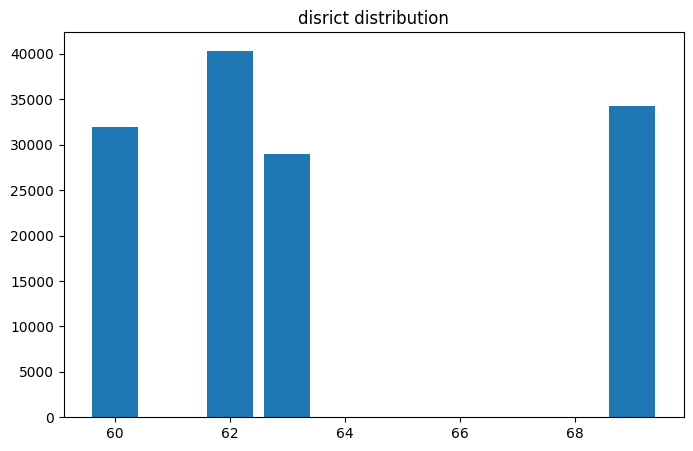

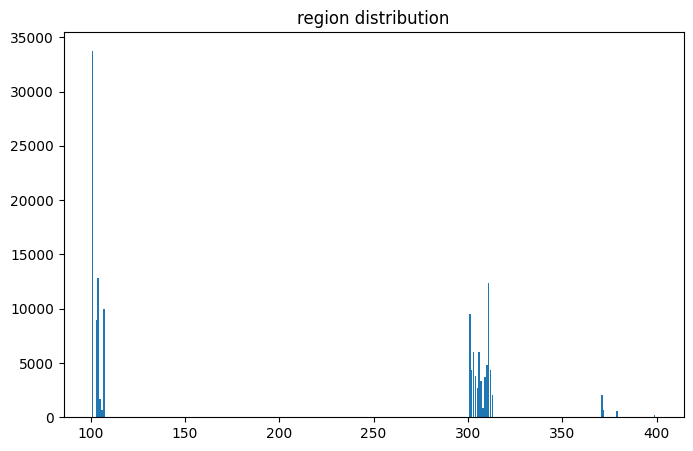

In [21]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

## Feature Engineering

In [22]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
#for df in [invoice_train,invoice_test]:
#    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [23]:
#encode labels in categorical column
#d={"ELEC":0,"GAZ":1}
#invoice_train['counter_type']=invoice_train['counter_type'].map(d)

In [24]:
#convert categorical columns to int for model
client['client_catg'] = client['client_catg'].astype('int32')
client['disrict'] = client['disrict'].astype('int32')

In [25]:
def aggregate_by_client_id(invoice_data):
    aggs = {} #define aggregation dictionary
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs) #invoice data is grouped by the client id and aggregated using the dict. aggs
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values] #new dataframe where each row represents a unique client_id and contains a mean of a consumption level specified
    #above the columns of agg_trans are renamed. This renaming concatenates the original column names (which are multi-level after the aggregation operation) into single-level column names by joining them with an underscore
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id') 
            .size()
            .reset_index(name='{}transactions_count'.format('1')))#we group the original invoice_data by client_id to count the number of transactions per client

    return pd.merge(df, agg_trans, on='client_id', how='left')#we merge the transaction count df with the counsumption level averages df agg_trans on client_id column

In [26]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice)
#this will again compute the mean values of consommation_level_* grouped by client_id, rename the columns to consommation_level_*_mean, count the number of transactions for each client in invoce_data
#and merge these two sets of data (average consumption levels and transaction counts) into a single df

In [27]:
print(agg_train.shape)
agg_train.head()

(135493, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.40,10.57,0.00,0.00
1,train_Client_1,37,557.54,0.00,0.00,0.00
2,train_Client_10,18,798.61,37.89,0.00,0.00
3,train_Client_100,20,1.20,0.00,0.00,0.00
4,train_Client_1000,14,663.71,104.86,117.36,36.71


In [28]:
#merge aggregate data with client dataset
train = pd.merge(client,agg_train, on='client_id', how='left')
train.head(5)

,disrict,client_id,client_catg,region,creation_date,target,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,60,train_Client_0,11,101,31/12/1994,0.00,35,352.40,10.57,0.00,0.00
1,69,train_Client_1,11,107,29/05/2002,0.00,37,557.54,0.00,0.00,0.00
2,62,train_Client_10,11,301,13/03/1986,0.00,18,798.61,37.89,0.00,0.00
3,69,train_Client_100,11,105,11/07/1996,0.00,20,1.20,0.00,0.00,0.00
4,62,train_Client_1000,11,303,14/10/2014,0.00,14,663.71,104.86,117.36,36.71


## Train - Test Split

In [29]:
#drop redundant columns
sub_client_id = train['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)

In [30]:
y_base = train['target']
X_base = train.drop('target', axis=1)

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.2, random_state=RSEED, stratify=y_base)

In [31]:
X_train_base.shape, X_test_base.shape

((108394, 8), (27099, 8))

## Baseline

In [32]:
consumption_all = X_train_base.eval('consommation_level_1_mean + consommation_level_2_mean + consommation_level_3_mean + consommation_level_4_mean')
median_consumption = consumption_all.median()

# Generate binary predictions based on the median consumption
y_train_naive_pred = (consumption_all > median_consumption).astype(int)

# For the test set, ensure to calculate the consumption sum using test set features
consumption_test = X_test_base.eval('consommation_level_1_mean + consommation_level_2_mean + consommation_level_3_mean + consommation_level_4_mean')
y_test_naive_pred = (consumption_test > median_consumption).astype(int)

# Calculate metrics
metrics = {
    "Accuracy": [accuracy_score(y_test_base, y_test_naive_pred)],
    "Recall": [recall_score(y_test_base, y_test_naive_pred)],
    "Precision": [precision_score(y_test_base, y_test_naive_pred)],
    "F1-score": [f1_score(y_test_base, y_test_naive_pred)]
}

metrics_df = pd.DataFrame(metrics, index=["Baseline"])
print(metrics_df)

          Accuracy  Recall  Precision  F1-score
Baseline      0.51    0.57       0.06      0.11


## LGBM Classifier - Baseline

In [33]:
model_lgbmc_base = LGBMClassifier(boosting_type='gbdt', random_state=RSEED, n_jobs=-1, verbosity=-1)

model_lgbmc_base.fit(X_train_base, y_train_base)

predict_and_print_scores(model_lgbmc_base, X_train_base, y_train_base, X_test_base, y_test_base, matrix=False)

Accuracy on training set: 0.94
Accuracy on test set: 0.94
----------------------------------------
Recall on training set: 0.02
Recall on test set: 0.0
----------------------------------------
Precision on training set: 0.95
Precision on test set: 0.6
----------------------------------------
fbeta_score on training set: 0.03
fbeta_score on test set: 0.01
----------------------------------------
roc_auc_score on trainig set:  0.81
roc_auc_score on test set:  0.76
----------------------------------------


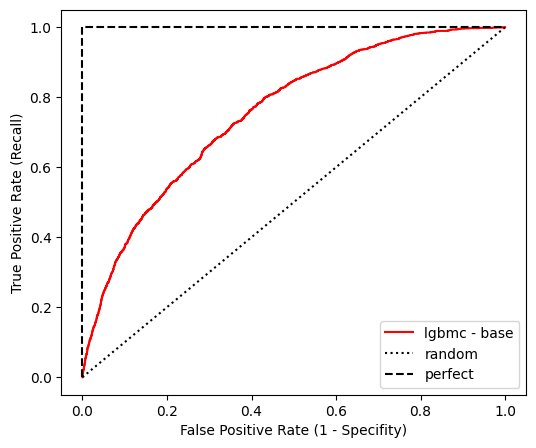

(<Figure size 600x500 with 1 Axes>,
 <Axes: xlabel='False Positive Rate (1 - Specifity)', ylabel='True Positive Rate (Recall)'>)

In [34]:
# Evaluate your model
model_dic={'lgbmc - base' : [model_lgbmc_base, 'r-']}
plot_roc_curves(model_dic, X_test_base, y_test_base)

## Feature engineering

In [35]:
#rename columns
client.rename(columns={
    'disrict': 'district',
}, inplace=True)

invoice.rename(columns={
    'counter_statue': 'counter_status',
    'reading_remarque': 'agent_remark',
    # Add more columns as needed
}, inplace=True)

In [36]:
# Convert to categories for eda viszualizations

# List of columns to convert to categorical
columns_to_convert = ['tarif_type', 'counter_code', 'months_number', 'counter_type']

# Convert each column in invoice
for column in columns_to_convert:
    invoice[column] = invoice[column].astype('category')

In [37]:
# List of columns to convert to categorical
columns_to_convert = ['client_id', 'region','district']

# Convert each column in client
for column in columns_to_convert:
    client[column] = client[column].astype('category')

In [38]:
# convert columns to integer, ensuring support for NaN values
columns_to_convert = ['target']

# Convert each column in client to a pandas nullable integer type
for column in columns_to_convert:
    client[column] = client[column].astype('int32')

In [39]:
# change strings in counter_status to integers

def convert_to_int(value):
    # Check if the value is 'A' and return 500
    if value == 'A':
        return 500
    # Try to convert numeric strings directly to int
    try:
        return int(value)
    # If conversion fails (which shouldn't happen with the given conditions), return the value
    except ValueError:
        return value
    
invoice['counter_status'] = invoice['counter_status'].apply(convert_to_int)

In [40]:
# convert columns to integer, ensuring support for NaN values
columns_to_convert = ['counter_status']

# Convert each column in client to a pandas nullable integer type
for column in columns_to_convert:
    invoice[column] = invoice[column].astype('int32')

In [41]:
#Change date to datetime
client['creation_date'] = pd.to_datetime(client['creation_date'])
#Change date to datetime
invoice['invoice_date'] = pd.to_datetime(invoice['invoice_date'])

In [42]:
# calculate total consumption per billing cycle per counter type

invoice['total_consumption'] = invoice[['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']].sum(axis=1)

In [43]:
# Filter the DataFrame for rows where 'counter_type' is 'ELEC'
invoice_elec = invoice[invoice['counter_type'] == 'ELEC']

# Then, aggregate total_consumption by client_id and counter type (which is now only 'ELEC')
aggregated_consumption_elec = invoice_elec.groupby('client_id')['total_consumption'].agg(
    elec_total_consumption='sum',  # Aggregate the total
    elec_min_consumption='min',
    elec_max_consumption='max',
    elec_mean_consumption='mean',
    elec_std_consumption='std',
    #elec_range_consumption=lambda x: x.max() - x.min()  # Calculate the range as max - min
).reset_index()

# Display the aggregated consumption for 'ELEC' counter type
#aggregated_consumption_elec.head()

In [44]:
# Filter the DataFrame for rows where 'counter_type' is 'GAZ'
invoice_gas = invoice[invoice['counter_type'] == 'GAZ']

# Then, aggregate total_consumption by client_id and counter type (which is now only 'ELEC')
aggregated_consumption_gas = invoice_gas.groupby('client_id')['total_consumption'].agg(
    gas_total_consumption='sum',  # Aggregate the total
    gas_min_consumption='min',
    gas_max_consumption='max',
    gas_mean_consumption='mean',
    gas_std_consumption='std',
    #gas_range_consumption=lambda x: x.max() - x.min()  # Calculate the range as max - min
).reset_index()

# Display the aggregated consumption for 'ELEC' counter type
#aggregated_consumption_gas.head()

In [45]:
invoice['counter_status'] = invoice['counter_status'].replace(500, 6)

invoice['counter_status'] = invoice['counter_status'].replace(769, 7)

invoice['counter_status'] = invoice['counter_status'].replace(618, 8)

invoice['counter_status'] = invoice['counter_status'].replace(269375, 9)

invoice['counter_status'] = invoice['counter_status'].replace(46, 10)

invoice['counter_status'] = invoice['counter_status'].replace(420, 11)

In [46]:
invoice['counter_status'].unique()

array([ 0,  1,  5,  4,  3,  2,  7,  6,  8,  9, 10, 11])

In [47]:
aggregated_counter_status = invoice.groupby('client_id')['counter_status'].agg(
    counter_status_min='min',
    counter_status_max='max',
    counter_status_mean='mean',
    counter_status_std='std',
    #counter_status_mode='most_frequent'
).reset_index()

#aggregated_counter_status

In [48]:
invoice['agent_remark'] = invoice['agent_remark'].replace(5, 1)
invoice['agent_remark'] = invoice['agent_remark'].replace(6, 2)
invoice['agent_remark'] = invoice['agent_remark'].replace(7, 3)
invoice['agent_remark'] = invoice['agent_remark'].replace(8, 4)
invoice['agent_remark'] = invoice['agent_remark'].replace(9, 5)
invoice['agent_remark'] = invoice['agent_remark'].replace(203, 6)
invoice['agent_remark'] = invoice['agent_remark'].replace(207, 7)
invoice['agent_remark'] = invoice['agent_remark'].replace(413, 8)

In [49]:
aggregated_agent_remark = invoice.groupby('client_id')['agent_remark'].agg(
    agent_remark_min='min',
    agent_remark_max='max',
    agent_remark_mean='mean',
    agent_remark_std='std',
    #agent_remark_mode='mode'
).reset_index()
#aggregated_agent_remark

In [50]:
aggregated_counter_coefficient = invoice.groupby('client_id')['counter_coefficient'].agg(
    counter_coefficient_min='min',
    counter_coefficient_max='max',
    counter_coefficient_mean='mean',
    counter_coefficient_std='std',
   # counter_coefficient_remark_mode='mode'
).reset_index()

#aggregated_counter_coefficient

In [51]:
# add transaction counts per counter_type
grouped_counts = invoice.groupby(['client_id', 'counter_type']).size().reset_index(name='count')

transaction_counts = grouped_counts.pivot(index='client_id', columns='counter_type', values='count').reset_index()

# Assuming 'ELEC' and 'GAS' are the two counter_type values you have
transaction_counts.columns = ['client_id'] + transaction_counts.columns[1:].tolist()

# Now rename the columns to specify elec and gas transactions explicitly
transaction_counts = transaction_counts.rename(columns={
    'ELEC': 'count_elec_transactions',
    'GAZ': 'count_gas_transactions'
})

In [52]:
# group by the relevant columns and count the occurrences.
tarif_freq = invoice.groupby(['client_id', 'counter_type', 'tarif_type']).size().reset_index(name='freq')

# Identify the max frequency per client_id and counter_type
max_freq = tarif_freq.groupby(['client_id', 'counter_type'])['freq'].transform(max) == tarif_freq['freq']

# Apply the filter
tarif_freq_max = tarif_freq[max_freq]

# In case of ties, we'll keep the first occurrence
tarif_freq_max = tarif_freq_max.drop_duplicates(subset=['client_id', 'counter_type'])

# Pivot to get separate columns for ELEC and GAZ tarif_type
tarif_pivot = tarif_freq_max.pivot(index='client_id', columns='counter_type', values='tarif_type').reset_index()

# Rename columns to 'elec_tarif' and 'gaz_tarif'
tarif_pivot.columns = ['client_id', 'elec_tarif', 'gaz_tarif']
tarif_pivot.head()

,client_id,elec_tarif,gaz_tarif
0,train_Client_0,11,8
1,train_Client_1,11,8
2,train_Client_10,11,8
3,train_Client_100,11,8
4,train_Client_1000,11,8


In [53]:
# Sort invoice DataFrame by 'client_id', 'counter_type', and 'invoice_date'
invoice_sorted = invoice.sort_values(['client_id', 'counter_type', 'invoice_date'])

# Calculate the difference in days between invoice dates within each group of 'client_id' and 'counter_type'
invoice_sorted['invoice_delta_time'] = invoice_sorted.groupby(['client_id', 'counter_type'])['invoice_date'].diff().dt.days

# Create a new DataFrame focusing on the columns of interest
date_eda = invoice_sorted[['client_id', 'counter_type', 'invoice_date', 'invoice_delta_time']].copy()

# Sort this new DataFrame by 'client_id', 'counter_type', and 'invoice_date'
date_eda_sorted = date_eda.sort_values(['client_id', 'counter_type', 'invoice_date'])

In [54]:
# Sort invoice DataFrame by 'client_id', 'counter_type', and 'invoice_date'
invoice_sorted = invoice.sort_values(['client_id', 'counter_type', 'invoice_date'])

# Calculate the difference in days between invoice dates within each group of 'client_id' and 'counter_type'
invoice_sorted['invoice_delta_time'] = invoice_sorted.groupby(['client_id', 'counter_type'])['invoice_date'].diff().dt.days

# Create a new DataFrame focusing on the columns of interest
date_eda = invoice_sorted[['client_id', 'counter_type', 'invoice_date', 'invoice_delta_time']].copy()

# Sort this new DataFrame by 'client_id', 'counter_type', and 'invoice_date'
date_eda_sorted = date_eda.sort_values(['client_id', 'counter_type', 'invoice_date'])

In [55]:
# Filter the DataFrame for rows where 'counter_type' is 'ELEC'
date_elec = date_eda_sorted[date_eda_sorted['counter_type'] == 'ELEC']

# Group by both 'client_id' and 'counter_type', then calculate the aggregate statistics for 'invoice_delta_time'
aggregated_elec_date_stats = date_elec.groupby(['client_id'])['invoice_delta_time'].agg(
    elec_min_invoice_delta='min',
    elec_max_invoice_delta='max',
    elec_mean_invoice_delta='mean',
    #elec_median_invoice_delta='median',
    elec_std_invoice_delta='std'
).reset_index()
#aggregated_elec_date_stats

In [56]:
# Filter the DataFrame for rows where 'counter_type' is 'GAZ'
date_gas = date_eda_sorted[date_eda_sorted['counter_type'] == 'GAZ']

# Group by both 'client_id' and 'counter_type', then calculate the aggregate statistics for 'invoice_delta_time'
aggregated_gas_date_stats = date_gas.groupby(['client_id'])['invoice_delta_time'].agg(
    gas_min_invoice_delta='min',
    gas_max_invoice_delta='max',
    gas_mean_invoice_delta='mean',
    #gas_median_invoice_delta='median',
    gas_std_invoice_delta='std'
).reset_index()

In [57]:
# List of columns you want to include in the new DataFrame
columns_to_include = ['client_id', 'client_catg', 'region', 'creation_date', 'target']

# Create a new DataFrame with the specified columns
model_df = client[columns_to_include].copy()

In [58]:
model_df = model_df.merge(aggregated_counter_status[['client_id',
                                                     'counter_status_min',
                                                     'counter_status_max',
                                                     'counter_status_mean',
                                                     'counter_status_std']], on='client_id', how='left')

model_df = model_df.merge(aggregated_agent_remark[['client_id',
                                                   'agent_remark_min',
                                                   'agent_remark_max',
                                                   'agent_remark_mean',
                                                   'agent_remark_std']], on='client_id', how='left')

model_df = model_df.merge(aggregated_counter_coefficient[['client_id',
                                                          'counter_coefficient_min',
                                                          'counter_coefficient_max',
                                                          'counter_coefficient_mean',
                                                          'counter_coefficient_std']], on='client_id', how='left')

model_df = model_df.merge(transaction_counts[['client_id', 
                                              'count_elec_transactions', 
                                              'count_gas_transactions']], on='client_id', how='left')

model_df = model_df.merge(tarif_pivot[['client_id', 'elec_tarif', 'gaz_tarif']], on='client_id', how='left')

In [59]:
model_df = model_df.merge(aggregated_consumption_elec[['client_id',
                                                       'elec_total_consumption',
                                                       'elec_min_consumption',
                                                       'elec_max_consumption',
                                                       'elec_mean_consumption',
                                                       'elec_std_consumption']], on='client_id', how='left')


model_df = model_df.merge(aggregated_consumption_gas[['client_id',
                                                      'gas_total_consumption',
                                                      'gas_min_consumption',
                                                      'gas_max_consumption',
                                                      'gas_mean_consumption',
                                                      'gas_std_consumption']], on='client_id', how='left')

model_df = model_df.merge(aggregated_elec_date_stats[['client_id',
                                                      'elec_min_invoice_delta',
                                                      'elec_max_invoice_delta',
                                                      'elec_mean_invoice_delta',
                                                      'elec_std_invoice_delta']], on='client_id', how='left')

model_df = model_df.merge(aggregated_gas_date_stats[['client_id',
                                                     'gas_min_invoice_delta',
                                                     'gas_max_invoice_delta',
                                                     'gas_mean_invoice_delta',
                                                     'gas_std_invoice_delta']], on='client_id', how='left')



In [60]:
#model_df.head()

In [61]:
model_df['coop_time'] = (2019 - model_df['creation_date'].dt.year)*12 - model_df['creation_date'].dt.month

In [62]:
#model_df.head(30)

In [63]:
columns_to_convert = ['client_catg', 'agent_remark_min', 'agent_remark_max', 'counter_coefficient_min', 'counter_coefficient_max', 'count_elec_transactions', 'count_gas_transactions', ]

for column in columns_to_convert:
    model_df[column] = model_df[column].astype('int32')

In [64]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 40 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   client_id                 135493 non-null  object        
 1   client_catg               135493 non-null  int32         
 2   region                    135493 non-null  category      
 3   creation_date             135493 non-null  datetime64[ns]
 4   target                    135493 non-null  int32         
 5   counter_status_min        135493 non-null  int32         
 6   counter_status_max        135493 non-null  int32         
 7   counter_status_mean       135493 non-null  float64       
 8   counter_status_std        131281 non-null  float64       
 9   agent_remark_min          135493 non-null  int32         
 10  agent_remark_max          135493 non-null  int32         
 11  agent_remark_mean         135493 non-null  float64       
 12  ag

In [65]:
#model_df.head()

### Modeling 

In [66]:
#drop redundant columns
model_df_copy = model_df.copy()
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in model_df_copy.columns:
        model_df_copy.drop([col], axis=1, inplace=True)
        
model_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   client_catg               135493 non-null  int32   
 1   region                    135493 non-null  category
 2   target                    135493 non-null  int32   
 3   counter_status_min        135493 non-null  int32   
 4   counter_status_max        135493 non-null  int32   
 5   counter_status_mean       135493 non-null  float64 
 6   counter_status_std        131281 non-null  float64 
 7   agent_remark_min          135493 non-null  int32   
 8   agent_remark_max          135493 non-null  int32   
 9   agent_remark_mean         135493 non-null  float64 
 10  agent_remark_std          131281 non-null  float64 
 11  counter_coefficient_min   135493 non-null  int32   
 12  counter_coefficient_max   135493 non-null  int32   
 13  counter_coefficient_mean  135

### Train - Test Split 

In [67]:
y = model_df_copy['target']
X = model_df_copy.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((108394, 37), (27099, 37), (108394,), (27099,))

## LGBM Classifier 1 (with Enhanced Features, OneHot)

In [68]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category']).columns
class_ratio = math.sqrt((y_train == 0).sum() / (y_train == 1).sum())

# preprocessing for numerical columns
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
    #('imputer', SimpleImputer(strategy='most_frequent'))
    #('scaler', RobustScaler())
])

# preprocessing for categorical data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# apply different preprocessing to num and cat features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

model_lgbmc_1 = Pipeline([
    ('prep', preprocessor),
    #('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('lgbmc', LGBMClassifier(boosting_type='gbdt', random_state=RSEED, scale_pos_weight=class_ratio, n_jobs=-1, verbosity=-1))
]) 

model_lgbmc_1.fit(X_train, y_train)

predict_and_print_scores(model_lgbmc_1, X_train, y_train, X_test, y_test, matrix=False)

Accuracy on training set: 0.94
Accuracy on test set: 0.93
----------------------------------------
Recall on training set: 0.24
Recall on test set: 0.14
----------------------------------------
Precision on training set: 0.43
Precision on test set: 0.28
----------------------------------------
fbeta_score on training set: 0.31
fbeta_score on test set: 0.19
----------------------------------------
roc_auc_score on trainig set:  0.87
roc_auc_score on test set:  0.78
----------------------------------------


## LGBM Classifier 2 (with Enhanced Features)

In [69]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category']).columns
class_ratio = math.sqrt((y_train == 0).sum() / (y_train == 1).sum())

# preprocessing for numerical columns
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
    #('scaler', RobustScaler())
])

# preprocessing for categorical data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# apply different preprocessing to num and cat features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

model_lgbmc_2 = Pipeline([
    ('prep', preprocessor),
    ('lgbmc', LGBMClassifier(boosting_type='gbdt', random_state=RSEED, scale_pos_weight=class_ratio, n_jobs=-1, verbosity=-1))
]) 

model_lgbmc_2.fit(X_train, y_train)

predict_and_print_scores(model_lgbmc_2, X_train, y_train, X_test, y_test, matrix=False)

# Get the LGBMClassifier step from the pipeline

Accuracy on training set: 0.94
Accuracy on test set: 0.93
----------------------------------------
Recall on training set: 0.25
Recall on test set: 0.15
----------------------------------------
Precision on training set: 0.42
Precision on test set: 0.28
----------------------------------------
fbeta_score on training set: 0.31
fbeta_score on test set: 0.2
----------------------------------------
roc_auc_score on trainig set:  0.87
roc_auc_score on test set:  0.78
----------------------------------------


## LGBM Classifier 3 (with Enhanced Features and CV)

Best params: {'lgbmc__num_leaves': 50, 'lgbmc__n_estimators': 20, 'lgbmc__max_depth': 10, 'lgbmc__learning_rate': 1}
----------------------------------------
Accuracy on training set: 0.62
Accuracy on test set: 0.6
----------------------------------------
Recall on training set: 0.96
Recall on test set: 0.71
----------------------------------------
Precision on training set: 0.12
Precision on test set: 0.09
----------------------------------------
fbeta_score on training set: 0.22
fbeta_score on test set: 0.16
----------------------------------------
roc_auc_score on trainig set:  0.86
roc_auc_score on test set:  0.71
----------------------------------------


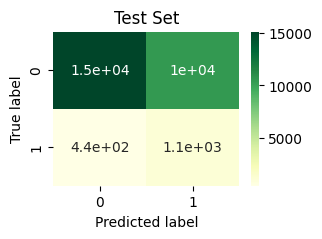

In [70]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category']).columns
class_ratio = math.sqrt((y_train == 0).sum() / (y_train == 1).sum())

# preprocessing for numerical columns
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# preprocessing for categorical data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# apply different preprocessing to num and cat features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

model_lgbmc_pipe = ImbPipeline([
    ('prep', preprocessor),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('lgbmc', LGBMClassifier(boosting_type='gbdt', random_state=RSEED, scale_pos_weight=class_ratio, n_jobs=-1, verbosity=-1))
]) 

hyperparameters = {
    'lgbmc__max_depth': [5, 7, 10, 50, 100],
    'lgbmc__num_leaves': [1, 5, 10, 30, 50, 100, 200, 500],
    'lgbmc__n_estimators': [5, 10, 20, 50, 100, 500, 1000, 1], 
    'lgbmc__learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
    #'min_split_gain': [0.001, 0.005, 0.01],
    #'feature_fraction': [0.1, 0.5, 1.0],
    #'bagging_freq': [0.1, 1, 10]
}

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

# Train, cross-validate, predict, score
model_lgbmc_3, params_lgbmc_3, _, _ = train_crossval_predict_score(
    model_lgbmc_pipe,
    hyperparameters,    
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    scoring='f1',
    verbose=0,
    n_jobs=-1,
    cross_val='random',
    random_state=None,
    training=True,
    test=True,
    accuracy=True,
    recall=True,
    precision=True,
    fbeta=[True, 1.0],
    roc_auc=True,
    matrix=True,
    figsize=(3,2),
    cmap='YlGn')

## XGB Boost

Best params: {'xgbc__subsample': 0.5, 'xgbc__n_estimators': 10, 'xgbc__max_depth': 20, 'xgbc__learning_rate': 0.01, 'xgbc__colsample_bytree': 1.0}
----------------------------------------
Accuracy on training set: 0.92
Accuracy on test set: 0.86
----------------------------------------
Recall on training set: 1.0
Recall on test set: 0.34
----------------------------------------
Precision on training set: 0.43
Precision on test set: 0.16
----------------------------------------
fbeta_score on training set: 0.6
fbeta_score on test set: 0.22
----------------------------------------
roc_auc_score on trainig set:  0.99
roc_auc_score on test set:  0.75
----------------------------------------


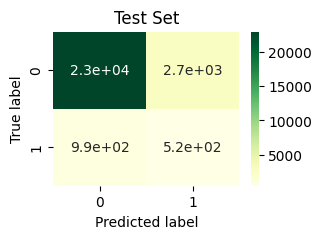

In [71]:
#model_xgb = XGBClassifier(objective='binary:logistic', seed=RSEED, use_label_encoder=False, eval_metric='logloss')
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category']).columns

# preprocessing for numerical columns
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# preprocessing for categorical data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# apply different preprocessing to num and cat features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

model_xgbc_pipe = ImbPipeline([
    ('prep', preprocessor),
    #('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('oversample', RandomOverSampler(sampling_strategy='minority')),
    ('xgbc', XGBClassifier(n_jobs=-1))
]) 

hyperparameters = {
    'xgbc__n_estimators': [1, 5, 10, 20, 50, 100], 
    'xgbc__learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
    'xgbc__max_depth': [3, 5, 7, 10, 20], 
    'xgbc__colsample_bytree': [0.5, 0.75, 1.0],  
    'xgbc__subsample': [0.5, 0.75, 1.0] 
}

#model_xgb = XGBClassifier()
#model_xgb.fit(X_train, y_train)
#predict_and_print_scores(model_xgb, X_train, y_train, X_test, y_test, training=False, matrix=False)

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

# Train, cross-validate, predict, score
model_xgbc_1, params_xgbc_1, _, _ = train_crossval_predict_score(
    model_xgbc_pipe,
    hyperparameters,    
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    scoring='f1',
    verbose=0,
    n_jobs=-1,
    cross_val='random',
    random_state=None,
    training=True,
    test=True,
    accuracy=True,
    recall=True,
    precision=True,
    fbeta=[True, 1.0],
    roc_auc=True,
    matrix=True,
    figsize=(3,2),
    cmap='YlGn')


#model_xgbc_1.fit(X_train, y_train)
#predict_and_print_scores(model_xgbc_1, X_train, y_train, X_test, y_test, matrix=False)

In [72]:
## ADA Boost

In [73]:
#model_xgb = XGBClassifier(objective='binary:logistic', seed=RSEED, use_label_encoder=False, eval_metric='logloss')
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category']).columns

# preprocessing for numerical columns
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# preprocessing for categorical data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# apply different preprocessing to num and cat features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

model_ada_pipe = ImbPipeline([
    ('prep', preprocessor),
    #('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('oversample', RandomOverSampler(sampling_strategy='minority')),
    ('ada', AdaBoostClassifier(random_state=RSEED))
]) 

model_ada_pipe.fit(X_train, y_train)
predict_and_print_scores(model_ada_pipe, X_train, y_train, X_test, y_test, matrix=False)

Accuracy on training set: 0.64
Accuracy on test set: 0.64
----------------------------------------
Recall on training set: 0.76
Recall on test set: 0.73
----------------------------------------
Precision on training set: 0.11
Precision on test set: 0.11
----------------------------------------
fbeta_score on training set: 0.19
fbeta_score on test set: 0.19
----------------------------------------
roc_auc_score on trainig set:  0.77
roc_auc_score on test set:  0.76
----------------------------------------


In [74]:
## Random Forest

Best params: {'rf__n_estimators': 300, 'rf__min_samples_split': 30, 'rf__max_features': 10, 'rf__max_depth': 7}
----------------------------------------
Accuracy on training set: 0.87
Accuracy on test set: 0.86
----------------------------------------
Recall on training set: 0.4
Recall on test set: 0.37
----------------------------------------
Precision on training set: 0.18
Precision on test set: 0.17
----------------------------------------
fbeta_score on training set: 0.25
fbeta_score on test set: 0.23
----------------------------------------
roc_auc_score on trainig set:  0.79
roc_auc_score on test set:  0.76
----------------------------------------


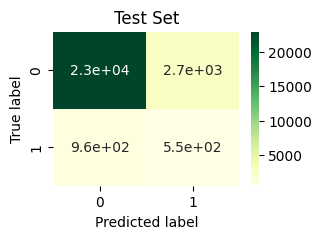

In [75]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category']).columns

# preprocessing for numerical columns
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# preprocessing for categorical data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# apply different preprocessing to num and cat features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

model_rf_pipe = ImbPipeline([
    ('prep', preprocessor),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    #('oversample', RandomOverSampler(sampling_strategy='minority')),
    ('rf', RandomForestClassifier(random_state=RSEED, max_features = 'sqrt', n_jobs=-1, verbose = 0))
])

hyperparameters = {
    'rf__n_estimators': [300], 
    'rf__max_depth': [3, 5, 7], 
    'rf__min_samples_split': [10, 20, 30],
    'rf__max_features': ['sqrt', 10]
}

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

# Train, cross-validate, predict, score
model_rf_1, params_rf_1, _, _ = train_crossval_predict_score(
    model_rf_pipe,
    hyperparameters,    
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    scoring='f1',
    verbose=0,
    n_jobs=-1,
    cross_val='random',
    random_state=None,
    training=True,
    test=True,
    accuracy=True,
    recall=True,
    precision=True,
    fbeta=[True, 1.0],
    roc_auc=True,
    matrix=True,
    figsize=(3,2),
    cmap='YlGn')

#model_rf_pipe.fit(X_train, y_train)
#predict_and_print_scores(model_rf_pipe, X_train, y_train, X_test, y_test, training=False, matrix=False)

In [94]:
#model1 = LogisticRegression(random_state = RSEED)
#model2 =  KNeighborsClassifier()
#model3 = DecisionTreeClassifier(random_state = RSEED)

model_ensemble = VotingClassifier(estimators = [('lgbmc', model_lgbmc_2), ('xgbc', model_xgbc_1), ('ada', model_ada_pipe), ('rf', model_rf_1)], voting = 'soft')
model_ensemble.fit(X_train, y_train)
#predict_and_print_scores(model_ensemble, X_train, y_train, X_test, y_test, matrix=False)

VotingClassifier(estimators=[('lgbmc',
                              Pipeline(steps=[('prep',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(fill_value=0,
                                                                                                               strategy='constant'))]),
                                                                                Index(['counter_status_mean', 'counter_status_std', 'agent_remark_mean',
       'agent_remark_std', 'counter_coefficient_mean',
       'counter_coefficient_std', 'elec_total_consumption',
       'ele...
      dtype='object')),
                                                                               ('cat',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(fill_value=0,
                                                                                                               strategy='constant'))]),
                                                                                Index(['region', 'elec_tarif', 'gaz_tarif'], dtype='object'))])),
                                              ('undersample',
                                               RandomUnderSampler(sampling_strategy=0.5)),
                                              ('rf',
                                               RandomForestClassifier(max_depth=7,
                                                                      max_features=10,
                                                                      min_samples_split=30,
                                                                      n_estimators=300,
                                                                      n_jobs=-1,
                                                                      random_state=42))]))],
                 voting='soft')

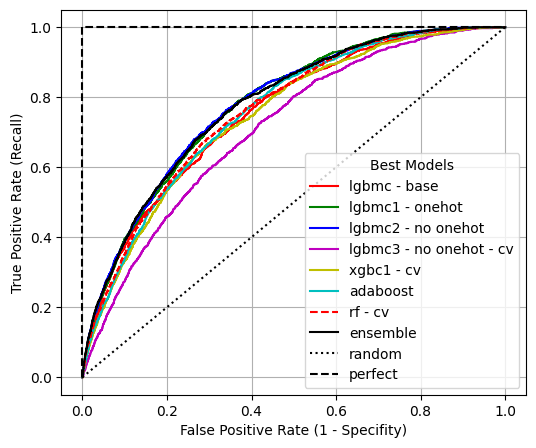

In [95]:
fpr_base, tpr_base, thresholds_base = roc_curve(y_test_base, model_lgbmc_base.predict_proba(X_test_base)[:,1])
fpr_lgbmc1, tpr_lgbmc1, thresholds_lgbmc1 = roc_curve(y_test, model_lgbmc_1.predict_proba(X_test)[:,1])
fpr_lgbmc2, tpr_lgbmc2, thresholds_lgbmc2 = roc_curve(y_test, model_lgbmc_2.predict_proba(X_test)[:,1])
fpr_lgbmc3, tpr_lgbmc3, thresholds_lgbmc3 = roc_curve(y_test, model_lgbmc_3.predict_proba(X_test)[:,1])
fpr_xgbc1, tpr_xgbc1, thresholds_xgbc1 = roc_curve(y_test, model_xgbc_1.predict_proba(X_test)[:,1])
fpr_ada_pipe, tpr_ada_pipe, thresholds_pipe = roc_curve(y_test, model_ada_pipe.predict_proba(X_test)[:,1])
fpr_rf_1, tpr_rf_1, thresholds_rf_1 = roc_curve(y_test, model_rf_1.predict_proba(X_test)[:,1])
fpr_ensem, tpr_ensem, thresholds_ensem = roc_curve(y_test, model_ensemble.predict_proba(X_test)[:,1])

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot()
plt.plot(fpr_base, tpr_base,'r-',label = 'lgbmc - base')
plt.plot(fpr_lgbmc1, tpr_lgbmc1,'g-', label= 'lgbmc1 - onehot')
plt.plot(fpr_lgbmc2, tpr_lgbmc2,'b-', label= 'lgbmc2 - no onehot')
plt.plot(fpr_lgbmc3, tpr_lgbmc3,'m-', label= 'lgbmc3 - no onehot - cv')
plt.plot(fpr_xgbc1, tpr_xgbc1,'y-', label= 'xgbc1 - cv')
plt.plot(fpr_ada_pipe, tpr_ada_pipe,'c-', label= 'adaboost')
plt.plot(fpr_rf_1, tpr_rf_1,'r--', label= 'rf - cv')
plt.plot(fpr_ensem, tpr_ensem, 'k-', label = 'ensemble')

plt.plot([0,1],[0,1],'k:',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'k--',label='perfect')
plt.legend(title='Best Models')
plt.xlabel('False Positive Rate (1 - Specifity)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()

In [79]:
thr, score = find_roc_threshold_f1(model_lgbmc_2, X_test, y_test)
print(f"Best threshold: {thr}")
print(f"Best f1 score: {score}")

Best threshold: 0.35
Best f1 score: 0.2516750418760469


In [84]:
thr_1, false_pos_rate = find_roc_threshold_tpr(model_lgbmc_2, X_test, y_test, 0.8)
print(f"Threshold for tpr of {thr_1}")
print(f"False positive rate: {false_pos_rate}")

Threshold for tpr of 0.1563014322391852
False positive rate: 0.3865785976706011


In [102]:
fpr, tpr, thr = roc_curve(y_test, model_lgbmc_2.predict_proba(X_test)[:,1])

old_diff = 100000000
for index, value in enumerate(tpr):
    new_diff = abs(0.8 - value)
    if new_diff <= old_diff:
        false_pos_rate = fpr[index]
        threshold = thr[index]
        old_diff = new_diff
print(f"Threshold for tpr of {threshold}")
print(f"False positive rate: {false_pos_rate}")  
old_diff

Threshold for tpr of 0.1561853334964724
False positive rate: 0.38689126866254986


0.00026437541308665935

array([ 91,  67, 235, 166,   6,   0, 180, 140, 161, 208, 160,  78,  56,
        57,  56,  76, 145, 177, 153, 162,  70,  92, 103,  78, 208,  72,
         3])

In [89]:
# Get the LGBMClassifier step from the pipeline
lgbmc_step = model_lgbmc_2.named_steps['lgbmc']

# Access feature importances
feature_importances = lgbmc_step.feature_importances_

feature_names = X_train.columns

# Combine feature names and their importances into a dictionary, then sort by importance
importances_dict = dict(zip(feature_names, feature_importances))
sorted_importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)

# Displaying feature importances
for feature, importance in sorted_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: counter_status_min, Importance: 235
Feature: agent_remark_std, Importance: 208
Feature: gas_min_consumption, Importance: 208
Feature: agent_remark_min, Importance: 180
Feature: gaz_tarif, Importance: 177
Feature: counter_status_max, Importance: 166
Feature: elec_min_consumption, Importance: 162
Feature: agent_remark_mean, Importance: 161
Feature: counter_coefficient_min, Importance: 160
Feature: elec_total_consumption, Importance: 153
Feature: elec_tarif, Importance: 145
Feature: agent_remark_max, Importance: 140
Feature: elec_std_consumption, Importance: 103
Feature: elec_mean_consumption, Importance: 92
Feature: client_catg, Importance: 91
Feature: counter_coefficient_max, Importance: 78
Feature: gas_total_consumption, Importance: 78
Feature: count_gas_transactions, Importance: 76
Feature: gas_max_consumption, Importance: 72
Feature: elec_max_consumption, Importance: 70
Feature: region, Importance: 67
Feature: counter_coefficient_std, Importance: 57
Feature: counter_coeffici

## Tips 
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************